In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 128
class_map = {
    'Airplane': 0,
    'Automobile': 1,
    'Bird': 2,
    'Cat': 3,
    'Deer': 4,
    'Dog': 5,
    'Frog': 6,
    'Horse': 7,
    'Ship': 8,
    'Truck': 9
}
show_summary = True
show_dataset_analyze = False
show_incorrect_classifications = False
show_confustion_matrix = False

In [4]:
# Load Network and Print Summary
from cifar10.model import Net
from cifar10.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = Net().to(device)
    print_summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 32, 32, 32]              96
              ReLU-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
           Dropout-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           1,024
            Conv2d-7           [-1, 32, 32, 32]             288
            Conv2d-8           [-1, 32, 32, 32]           1,024
              ReLU-9           [-1, 32, 32, 32]               0
      BatchNorm2d-10           [-1, 32, 32, 32]              64
          Dropout-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
           Conv2d-13           [-1, 32, 32, 32]             288
           Conv2d-14           [-1, 32,

In [5]:
from cifar10.dataset import get_loader
from cifar10.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
## Calculate Class Scale
from cifar10.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader, class_map)

In [9]:
import time
import math

from cifar10.backpropagation import train, test, get_sgd_optimizer
from cifar10.utils import initialize_weights
from cifar10.scheduler import one_cycle_lr_custom
from cifar10.training import Training

# Train Params
epochs = 30
lr = 0.1
max_lr = 1.0
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

model = Net().apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(model, lr=lr)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    custom_scheduler,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 30
Lr: 0.1
Max Lr: 1.0
Batch Size: 128
Dropout: True


| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.100000 | 00m 32s | 1.701831  |        18766 | 37.53  % | 1.398001 |       4874 | 48.74% |
|     2 | 0.200000 | 00m 33s | 1.427648  |        24021 | 48.04  % | 1.369178 |       5248 | 52.48% |
|     3 | 0.300000 | 00m 33s | 1.243704  |        27627 | 55.25  % | 1.277511 |       5784 | 57.84% |
|     4 | 0.400000 | 00m 33s | 1.137916  |        29796 | 59.59  % | 1.118440 |       6182 | 61.82% |
|     5 | 0.500000 | 00m 34s | 1.078753  |        30717 | 61.43  % | 0.890224 |       6887 | 68.87% |
|     6 | 0.600000 | 00m 33s | 1.02879   |        31648 | 63.3   % | 1.013747 |       6550 | 65.5 % |
|     7 | 0.700000 | 00m 31s | 0.985822  |        32398 | 64.8   % | 1.065736 |       6614 | 66.14% |
|     8 | 0.800000 | 00m 32s | 0.952519  |        33184 | 66.37  % | 0.918882 |       6901 | 69.01% |


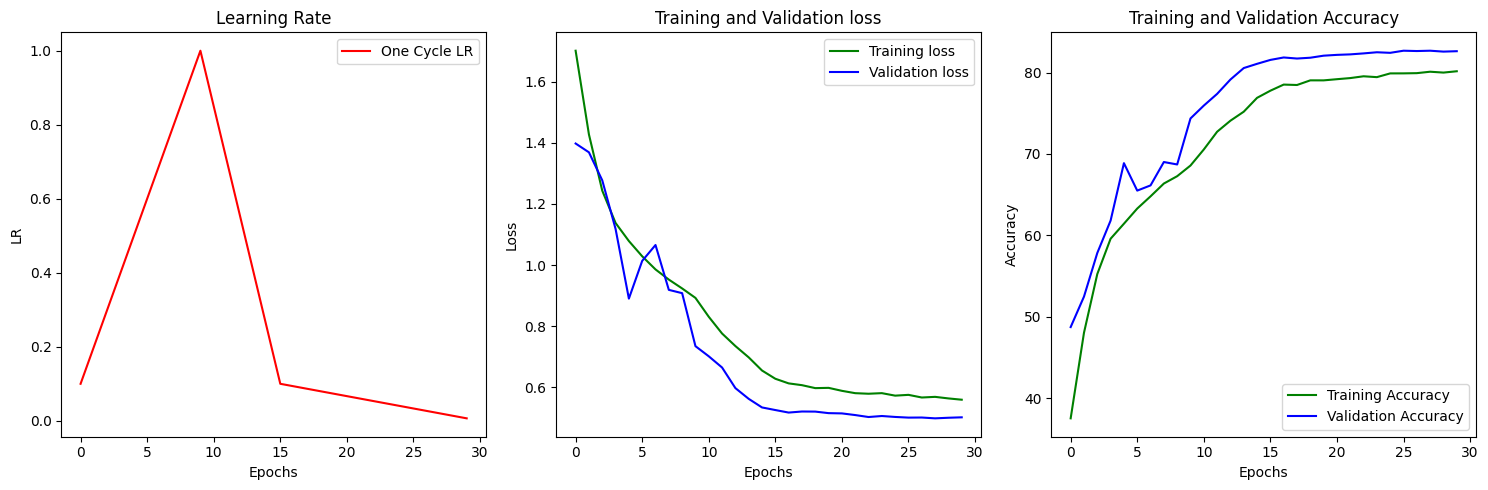

In [10]:
from cifar10.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

In [11]:
from cifar10.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from cifar10.visualize import plot_confusion_matrix

if show_confustion_matrix:
    all_preds, all_targets = get_all_predictions(model, test_loader, device)
    confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
    plot_confusion_matrix(confusion_matrix, class_map, False)

In [12]:
from cifar10.utils import get_incorrrect_predictions
from cifar10.visualize import plot_incorrect_predictions

if show_incorrect_classifications:
    incorrect = get_incorrrect_predictions(model, test_loader, device)
    plot_incorrect_predictions(incorrect, class_map)